In [1]:
import os
from pathlib import Path


os.chdir(Path(os.getcwd()).parent)

In [2]:
import torch
from mmcv import Config
from mmcv.runner import load_checkpoint
from mmseg.models.builder import build_segmentor
from mmseg.datasets import build_dataset
from pydantic import BaseSettings

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [5]:
class EnvSettings(BaseSettings):
    class Config:
        env_file: str = ".env"
        env_file_encoding: str = "utf-8"
    config_path: str
    checkpoint_path: str
env = EnvSettings()
env

EnvSettings(config_path='configs/base_nir/rgbir_deeplabv3_r50_s0.py', checkpoint_path='work_dirs/local-basic/220117_1053_loveda_r2u_warm_fdthings_rcs_croppl_a999_daformer_mitb5_s0_4b397/latest.pth')

In [6]:
cfg = Config.fromfile(env.config_path)

In [7]:
dataset = build_dataset(cfg.data.train)
classes = dataset.CLASSES
palette = dataset.PALETTE

2022-02-25 10:13:12,002 - mmseg - INFO - Loaded 56944 images
2022-02-25 10:13:13,263 - mmseg - INFO - Loaded 56944 images


In [8]:
def build_image(image: np.ndarray, label: np.ndarray, palette: list, opacity: float = 1.0, channels_first: bool = True):
    palette = np.array(palette)
    assert 0 <= opacity <= 1.0
    assert label.ndim == 2, "label must have 2 dimensions"
    if channels_first:
        image = image.transpose(1, 2, 0)
    color_label = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
    # convert to RGB
    for category, color in enumerate(palette):
        color_label[category == label, :] = color
    # mix image and label, if any
    img = image * (1 - opacity) + color_label * opacity
    return img.astype(np.uint8)

In [9]:
def denorm(img, mean, std):
    return torch.clamp((img.mul(std).add(mean) / 255.0), 0, 1)

In [10]:
mean = torch.tensor([123.675, 116.28, 103.53, 123.675])
std = torch.tensor([58.395, 57.12, 57.375, 58.395])
mean = torch.stack([mean]).view(-1, 4, 1, 1)
std = torch.stack([std]).view(-1, 4, 1, 1)

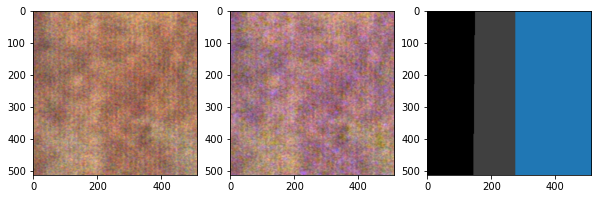

In [52]:
index = np.random.randint(0, len(dataset))
batch = dataset[index]
image_batch = batch["img"].data.unsqueeze(0)
label_batch = batch["gt_semantic_seg"].data

denormed = denorm(image_batch, mean=mean, std=std)
denormed_rgb = denormed[0,[0,1,3]].permute(1, 2, 0)
denormed_nir = denormed[0,[0,1,2]].permute(1, 2, 0)

lab_toplot = build_image(denormed_rgb.numpy(), label_batch[0].long().numpy(), palette=palette, opacity=1.0, channels_first=False)
img_toplot = build_image(denormed_rgb.numpy(), label_batch[0].long().numpy(), palette=palette, opacity=0.0, channels_first=False)

fig, axes = plt.subplots(1, 3, figsize=(10, 20))
axes[0].imshow(denormed_rgb)
axes[1].imshow(denormed_nir)
axes[2].imshow(lab_toplot)

In [ ]:
paldict = {i: c for i, c in enumerate(palette)}
paldict